In [1]:
import hpvsim as hpv
import time as t
import numpy as np
import pandas as pd
from itertools import product
import random as rn
import ast
import matplotlib.pyplot as plt
hpv.options(jupyter=True, verbose=0)

HPVsim 2.0.0 (2023-11-29) — © 2023 by IDM


## Parameters

In [2]:
#-------------------------------------------------------------
# Simulation parameters
#-------------------------------------------------------------
location = 'tunisia' 
start = 1990 # calibration reasons
end = 2090 
burnin = 20
dt = 0.25
dt_demog = 1
network = 'default'
ms_agent_ratio = 1
rel_birth = 1
rel_death = 1
sex_ratio = 0.5
rel_init_prev =1
rand_seed = 1
verbose = 0.25
use_migration = False

#-------------------------------------------------------------
# Initialization parameters
#-------------------------------------------------------------
init_hpv_prev = {
                'age_brackets': [30, 40, 50, 150], 
                'm': [0.124, 0.07, 0.064, 0.081], 
                'f': [0.124, 0.07, 0.064, 0.081]
                }
init_hpv_dist = {
                'hpv31': 0.019,
                'hpv16': 0.011,
                'hpv59': 0.0125,
                'hpv52': 0.012,
                'hpv18': 0.011,
                'hpv35': 0.0055,
                'hpv58': 0.0065,
                'hpv56': 0.0045,
                'hpv39': 0.0045, 
                'lr': 0.9135
                }


#-------------------------------------------------------------
# Sexual Behavior parameters
#-------------------------------------------------------------
cross_layer_options = [
    dict(
        f=0.05, # default value in HPVsim
        m=0.3, # default value in HPVsim
    ),
    dict(
        f=0.1, 
        m=0.25, 
    ),
]
cross_layer_option = cross_layer_options[1]  # change here for cross-layer mixing choice (0: default, 1: results of calibration for Tunisia)

f_cross_layer = cross_layer_option['f']
m_cross_layer = cross_layer_option['m']

debut = dict( 
    f = dict(dist='normal', par1=23, par2=3), # source: GTBC + INS
    m = dict(dist='normal', par1=22, par2=4),
)

dur_pship_options = [
    dict(
            m=dict(dist='neg_binomial', par1=80, par2=3), # This gives: mar_dur = {'0-5y': 0.015, '5-10y': 0.025, '10-20y':0.06, '20-50y':0.25, '50+':0.65}
            c=dict(dist='lognormal', par1=1, par2=2), # This gives: cas_dur = {'0-3m': 0.33, '3-6m': 0.22, '6-12m': 0.2, '1-2y':0.15, '2-5y':0.1}
    ),
    
    dict( # change casual ? 
            m=dict(dist='lognormal', par1=20, par2=26), 
            c=dict(dist='lognormal', par1=1, par2=2), # This gives: cas_dur = {'0-3m': 0.33, '3-6m': 0.22, '6-12m': 0.2, '1-2y':0.15, '2-5y':0.1}
    ),
]
dur_pship = dur_pship_options[1]  # change here for duration of partnership choice (0: default, 1: our assumption for Tunisia)

#defaults (do not change)
m_partners = dict(
    m=dict(dist='poisson1', par1=0.01), # Everyone in this layer has one marital partner; this captures *additional* marital partners. If using a poisson distribution, par1 is roughly equal to the proportion of people with >1 spouse
    c=dict(dist='poisson1', par1=0.5)
) # If using a poisson distribution, par1 is roughly equal to the proportion of people with >1 casual partner within a single time step

f_partners = dict(
    m=dict(dist="poisson1", par1=0.01),
    c=dict(dist='poisson', par1=1), # Defaults: {'0': 0.36, '1': 0.37, '2': 0.19, '3': 0.06, '4+':0.02}
)

layer_probs_options = [
    dict( #all default
            m=np.array([
                [ 0,  5,    10,    15,   20,   25,   30,   35,    40,    45,    50,   55,   60,   65,   70,   75],
                [ 0,  0,  0.01,   0.5,  0.5,  0.5,  0.5,  0.5,   0.5,   0.5,   0.5,  0.3,  0.2,  0.1, 0.05, 0.01], # Share of females of each age who are actively seeking marriage if underpartnered
                [ 0,  0,  0.01,   0.2,  0.3,  0.5,  0.5,  0.5,   0.5,   0.5,   0.5,  0.3,  0.2,  0.1, 0.05, 0.01]] # Share of males of each age who are actively seeking marriage if underpartnered
                # [ 1,  1,     1,     1,    1,    1,    1,    1,     1,     1,     1,    1,    1,    1,    1,    1]] # Share of males of each age who are actively seeking marriage if underpartnered
            ),
            c=np.array([
                [ 0,  5,    10,    15,   20,   25,   30,   35,    40,    45,    50,   55,   60,   65,   70,   75],
                [ 0,  0,   0.2,   0.6,  0.8,  0.6,  0.4,  0.4,   0.4,   0.1,  0.02, 0.02, 0.02, 0.02, 0.02, 0.02], # Share of females of each age actively seeking casual relationships if underpartnered
                [ 0,  0,   0.2,   0.4,  0.4,  0.4,  0.4,  0.6,   0.8,   0.6,   0.2,  0.1, 0.05, 0.02, 0.02, 0.02]] # Share of males of each age actively seeking casual relationships if underpartnered
            )
    ),
    dict(   # marital INS, casual default
        m=np.array([  # source: https://books.openedition.org/ined/18618?lang=en     
            [ 0,  5,    10,    15,   20,   25,   30,   35,    40,    45,    50,   55,   60,   65,   70,   75],
            [ 0,  0,  0.01,   0.1,  0.4,  0.7,  0.8,  0.7,   0.7,   0.6,   0.6,  0.3,  0.2,  0.1, 0.05, 0.01], # Females actively seeking marriage if underpartnered
            [ 0,  0,  0.01,   0.05,  0.1,  0.5,  0.5,  0.8,   0.8,   0.8,   0.7,  0.4,  0.2,  0.1, 0.05, 0.01]] # Males actively seeking marriage if underpartnered
        ),
        c=np.array([
                [ 0,  5,    10,    15,   20,   25,   30,   35,    40,    45,    50,   55,   60,   65,   70,   75],
                [ 0,  0,   0.2,   0.6,  0.8,  0.6,  0.4,  0.4,   0.4,   0.1,  0.02, 0.02, 0.02, 0.02, 0.02, 0.02], # Share of females of each age actively seeking casual relationships if underpartnered
                [ 0,  0,   0.2,   0.4,  0.4,  0.4,  0.4,  0.6,   0.8,   0.6,   0.2,  0.1, 0.05, 0.02, 0.02, 0.02]] # Share of males of each age actively seeking casual relationships if underpartnered
            )
    ),
    dict(   # marital INS, casual assumption
        m=np.array([  # source: https://books.openedition.org/ined/18618?lang=en     
            [ 0,  5,    10,    15,   20,   25,   30,   35,    40,    45,    50,   55,   60,   65,   70,   75],
            [ 0,  0,  0.01,   0.1,  0.4,  0.7,  0.8,  0.7,   0.7,   0.6,   0.6,  0.3,  0.2,  0.1, 0.05, 0.01], # Females actively seeking marriage if underpartnered
            [ 0,  0,  0.01,   0.05,  0.1,  0.5,  0.5,  0.8,   0.8,   0.8,   0.7,  0.4,  0.2,  0.1, 0.05, 0.01]] # Males actively seeking marriage if underpartnered
        ),
        c=np.array([  # assumption: casual relationships are less prevalent esp. with f .They are more common among younger people
            [ 0,  5,    10,    15,   20,   25,   30,   35,    40,    45,    50,   55,   60,   65,   70,   75],
            [ 0,  0,   0.01,  0.2,  0.4,  0.4,  0.2,  0.2,   0.2,   0.1,  0.02, 0.02, 0.02, 0.02, 0.02, 0.02], # Females actively seeking casual relationship if underpartnered
            [ 0,  0,   0.05,  0.5,  0.6,  0.7,  0.7,  0.7,   0.6,   0.4,   0.2,  0.1, 0.05, 0.01, 0.02, 0.02]] # Males actively seeking casual relationship if underpartnered
        )
    )
]

layer_probs = layer_probs_options[1]  # change here. 0: all default; 1: marital according INS and casual default; 2: marital INS and casual assumption. 

mixing_options = [
    np.array([  # source INS
        #       0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75   [F]
        [ 0,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 5,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [10,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [15,    0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [20,    0,  0,  0,  0, .1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [25,    0,  0,  0, .4, .7, .4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [30,    0,  0,  0,  1,  1,  1, .5, .1,  0,  0,  0,  0,  0,  0,  0,  0],
        [35,    0,  0,  0,  0, .6, .9,  1, .5, .1,  0,  0,  0,  0,  0,  0,  0],
        [40,    0,  0,  0, .2, .1, .3, .7,  1, .7, .1,  0,  0,  0,  0,  0,  0],
        [45,    0,  0,  0,  0,  0, .1, .3, .7,  1, .5, .1,  0,  0,  0,  0,  0],
        [50,    0,  0,  0,  0,  0,  0, .1, .2, .7,  1, .5, .1,  0,  0,  0,  0],
        [55,    0,  0,  0,  0,  0,  0,  0, .1, .2, .6,  1, .5, .1,  0,  0,  0],
        [60,    0,  0,  0,  0,  0,  0,  0,  0, .1, .2, .6,  1, .5, .1,  0,  0], 
        [65,    0,  0,  0,  0,  0,  0,  0,  0,  0, .1, .2, .6,  1, .5, .1,  0], 
        [70,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, .2, .6,  1, .5, .1],  
        [75,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, .2, .6,  1,  1],
]),

    np.array([
        #       0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75  [F]
        [ 0,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 5,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [10,    0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [15,    0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [20,    0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [25,    0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [30,    0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [35,    0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
        [40,    0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
        [45,    0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
        [50,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
        [55,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
        [60,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
        [65,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
        [70,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
        [75,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
]),
]

mixing_option = mixing_options[0]
# change here for mixing matrix choice (0: Tunisian from INS marital data, 1: Anas extrapolation 2: Diagonal)
mixing = dict()
mixing['m'] = mixing_option
mixing['c'] = np.array([
            #       0,  5,  10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75
            [ 0,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
            [ 5,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
            [10,    0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
            [15,    0,  0,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
            [20,    0,  0,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
            [25,    0,  0, .5,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0],
            [30,    0,  0,  0, .5,  1,  1,  1, .5,  0,  0,  0,  0,  0,  0,  0,  0],
            [35,    0,  0,  0, .5,  1,  1,  1,  1, .5,  0,  0,  0,  0,  0,  0,  0],
            [40,    0,  0,  0,  0, .5,  1,  1,  1,  1, .5,  0,  0,  0,  0,  0,  0],
            [45,    0,  0,  0,  0,  0,  1,  1,  1,  1,  1, .5,  0,  0,  0,  0,  0],
            [50,    0,  0,  0,  0,  0, .5,  1,  1,  1,  1,  1, .5,  0,  0,  0,  0],
            [55,    0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1, .5,  0,  0,  0],
            [60,    0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1, .5,  0,  0],
            [65,    0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1, .5,  0],
            [70,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1, .5],
            [75,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1],
        ])


#-------------------------------------------------------------
# Infection / Transmission parameters
#-------------------------------------------------------------

condoms = dict(
    m = 0.01, #default
    c = 0.18 # source GTBC
)
beta = 0.13 # calibration
transm2f = 3 # calibration
transf2m = 1 # calibration
eff_condoms = 0.7 # default https://www.nejm.org/doi/10.1056/NEJMoa053284?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200www.ncbi.nlm.nih.gov


#-------------------------------------------------------------
# Genotypes
#-------------------------------------------------------------
genotypes = ['hpv31', 'hpv16', 'hpv59', 'hpv52', 'hpv18', 'hpv35', 'hpv58', 'hpv56', 'hpv39', 'lr']      
n_genotypes =  10

#-------------------------------------------------------------
#-------------------------------------------------------------
#-------------------------------------------------------------
tn_parameters = dict(
    location = location,
    dt = dt,
    dt_demog = dt_demog,
    network = network,
    start = start,
    end = end,
    burnin = burnin,
    debut = debut,
    m_partners = m_partners,
    f_partners = f_partners, 
    dur_pship = dur_pship,
    f_cross_layer = f_cross_layer,
    m_cross_layer = m_cross_layer,
    layer_probs = layer_probs,
    mixing = mixing,
    condoms = condoms,
    beta = beta,
    transm2f = transm2f,
    transf2m = transf2m,
    eff_condoms = eff_condoms,
    genotypes = genotypes,
    n_genotypes = n_genotypes,
    ms_agent_ratio = 1,
    rel_birth = 1,
    rel_death = 1,
    sex_ratio = 0.5,
    rel_init_prev =1,
    rand_seed = 1,
    verbose = 0.25,
    use_migration = False,
    init_hpv_prev = init_hpv_prev,
    init_hpv_dist = init_hpv_dist,
)


## Simulating different agent population sizes and different number of replicates for measuring simulation time

In [3]:
agents = [10000, 50000, 100000]
replicates = [1, 2, 3, 5, 10, 15, 20, 30]

times = []
for agent in agents:
    sub_time = []
    for replica in replicates :
        start_time = t.time()
        sim = hpv.Sim(tn_parameters, n_agents=agent, label='Tunisian Parameters')
        msim = hpv.MultiSim(sim)
        msim.run(n_runs=replica)
        elapsed_time = t.time() - start_time
        sub_time.append(elapsed_time)
    times.append(sub_time)
        

Loading location-specific demographic data for "tunisia"
Loading location-specific demographic data for "tunisia"
Loading location-specific demographic data for "tunisia"
Loading location-specific demographic data for "tunisia"
Loading location-specific demographic data for "tunisia"
Loading location-specific demographic data for "tunisia"
Loading location-specific demographic data for "tunisia"
Loading location-specific demographic data for "tunisia"
Loading location-specific demographic data for "tunisia"
Loading location-specific demographic data for "tunisia"
Loading location-specific demographic data for "tunisia"
Loading location-specific demographic data for "tunisia"
Loading location-specific demographic data for "tunisia"
Loading location-specific demographic data for "tunisia"
Loading location-specific demographic data for "tunisia"
Loading location-specific demographic data for "tunisia"
Loading location-specific demographic data for "tunisia"
Loading location-specific demog

## Visualizing spent time vs number of replicates

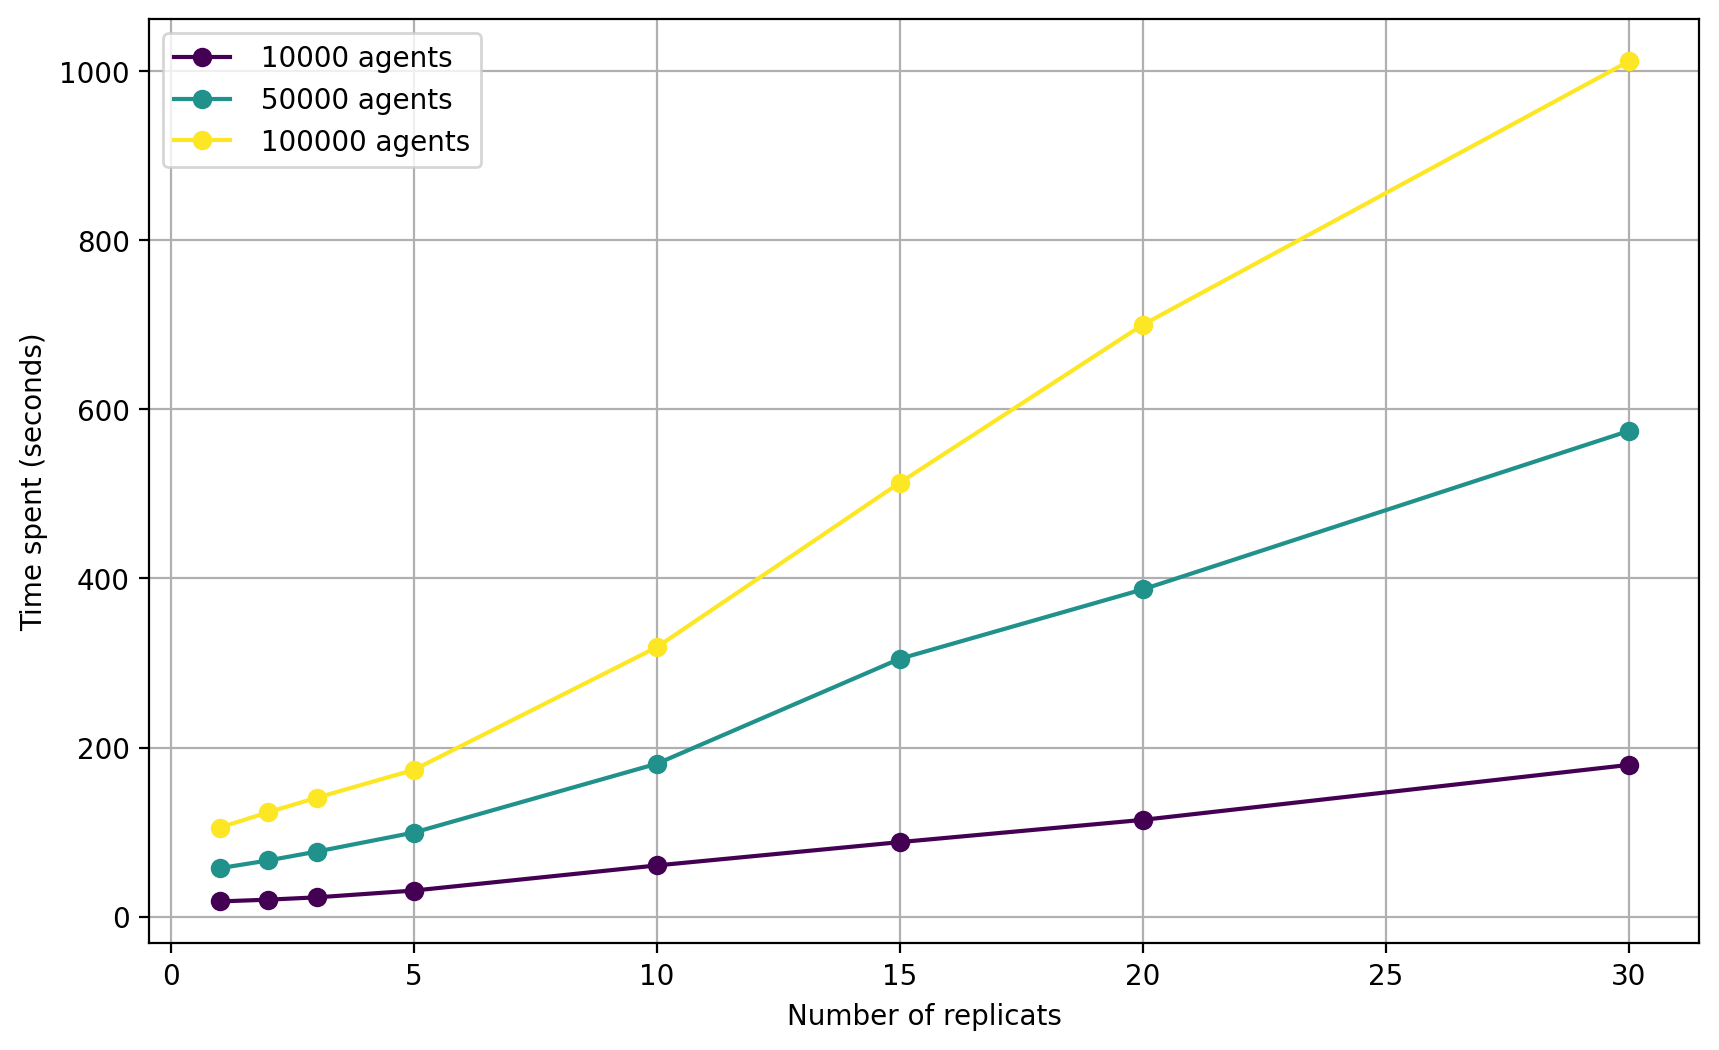

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(times))]

# Create the plot
plt.figure(figsize=(10, 6))

for i, sub_time in enumerate(times):
    plt.plot(replicates, sub_time, label=f' {agents[i]} agents', color=colors[i], marker='o')

plt.xlabel('Number of replicats')
plt.ylabel('Time spent (seconds)')
plt.legend()
plt.grid(True)
plt.show()


## Simulating different agent population sizes and sampling different for number of replicates (10 times) and calculating the average and standard deviation of total cancer cases for each sample

In [6]:
n = 60
agents = [10000, 50000, 100000]
sample_sizes = [1, 2, 3, 5, 10, 15, 20]
num_iteration = 10

all_result_means = []
all_result_std_dev = []

for agent in agents:
    sim = hpv.Sim(tn_parameters, n_agents=agent)
    msim = hpv.MultiSim(sim)
    msim.run(n_runs=n)
    
    result_means = []
    result_std_dev = []
    
    for sample_size in sample_sizes:
        sample_means = []
        sample_std_dev = []
        
        for i in range(num_iteration):
            sample_indices = np.random.choice(n, sample_size, replace=False)
            sample = [round(msim.sims[idx].results['cancers']['values'].sum()) for idx in sample_indices]
    
            mean = np.mean(sample)
            std_dev = np.std(sample)

            sample_means.append(mean)
            sample_std_dev.append(std_dev)
            
        result_means.append(sample_means)
        result_std_dev.append(sample_std_dev)

    all_result_means.append(result_means)
    all_result_std_dev.append(result_std_dev)




Loading location-specific demographic data for "tunisia"
Loading location-specific demographic data for "tunisia"
Loading location-specific demographic data for "tunisia"


## Evolution of the Mean vs number of replicates

In [11]:
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, 7)]

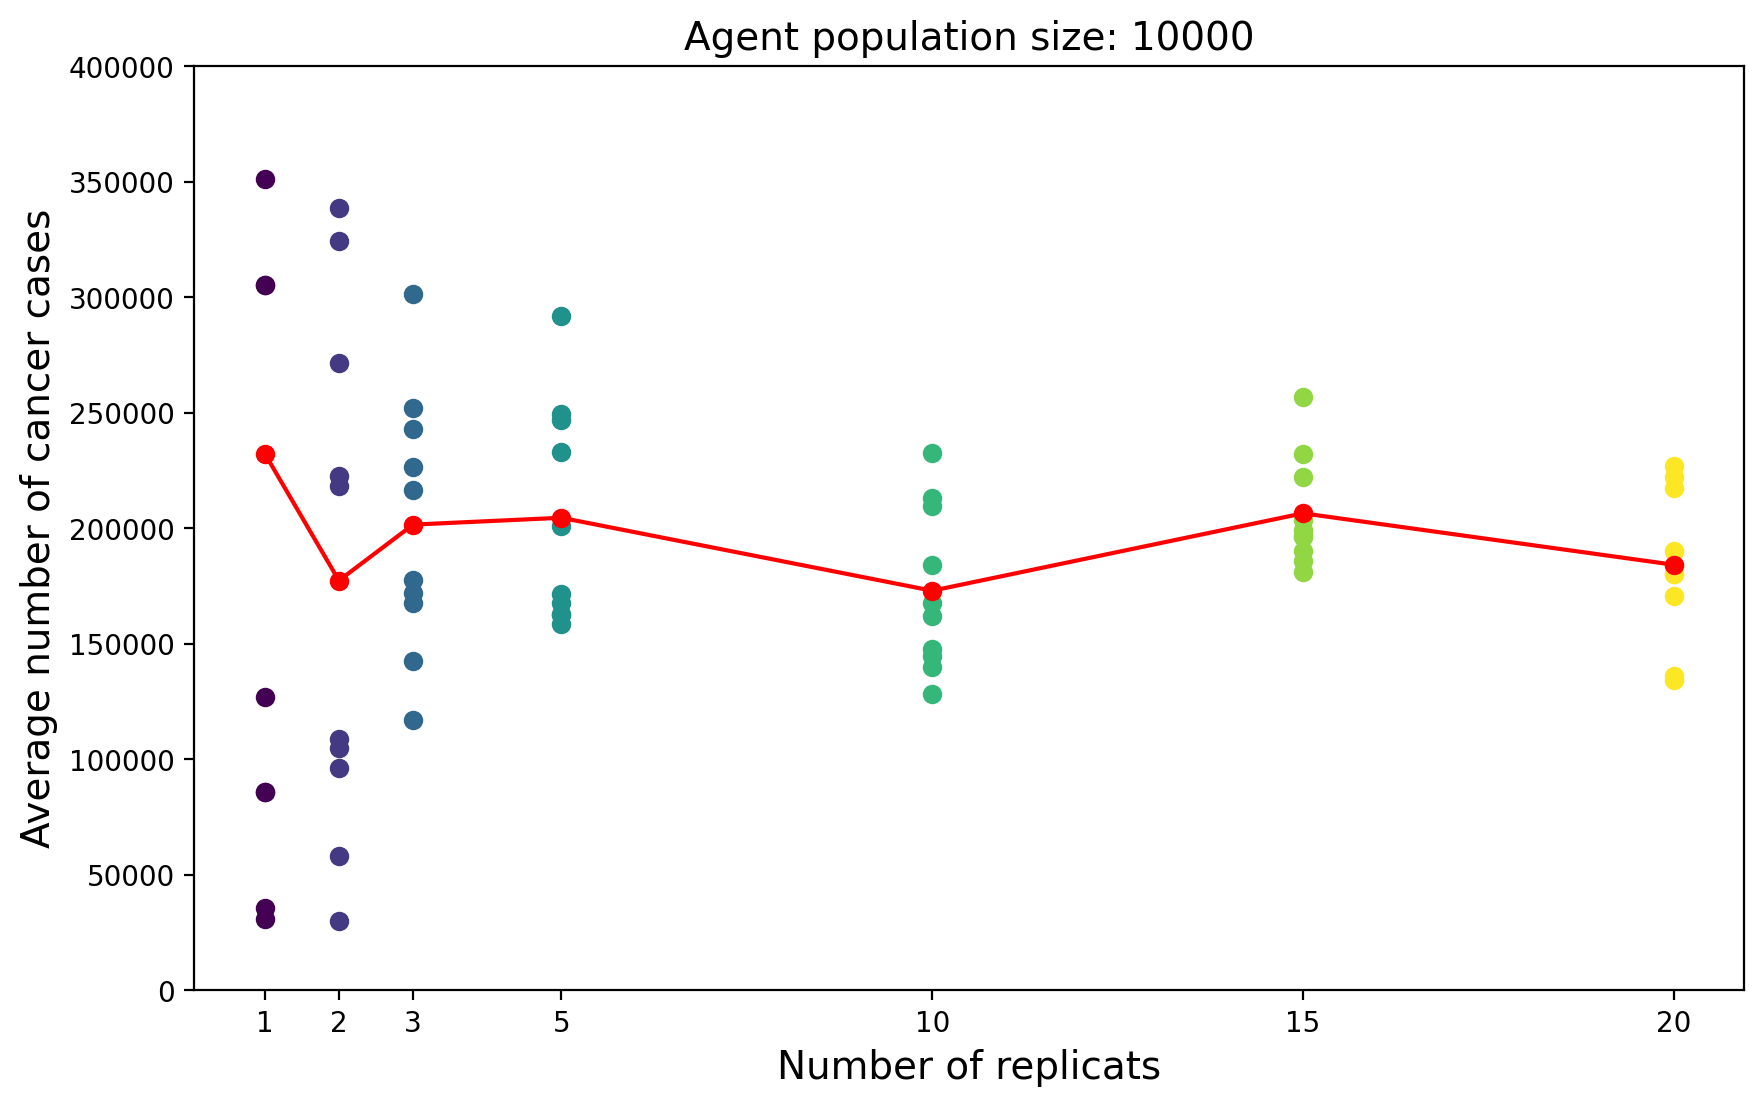

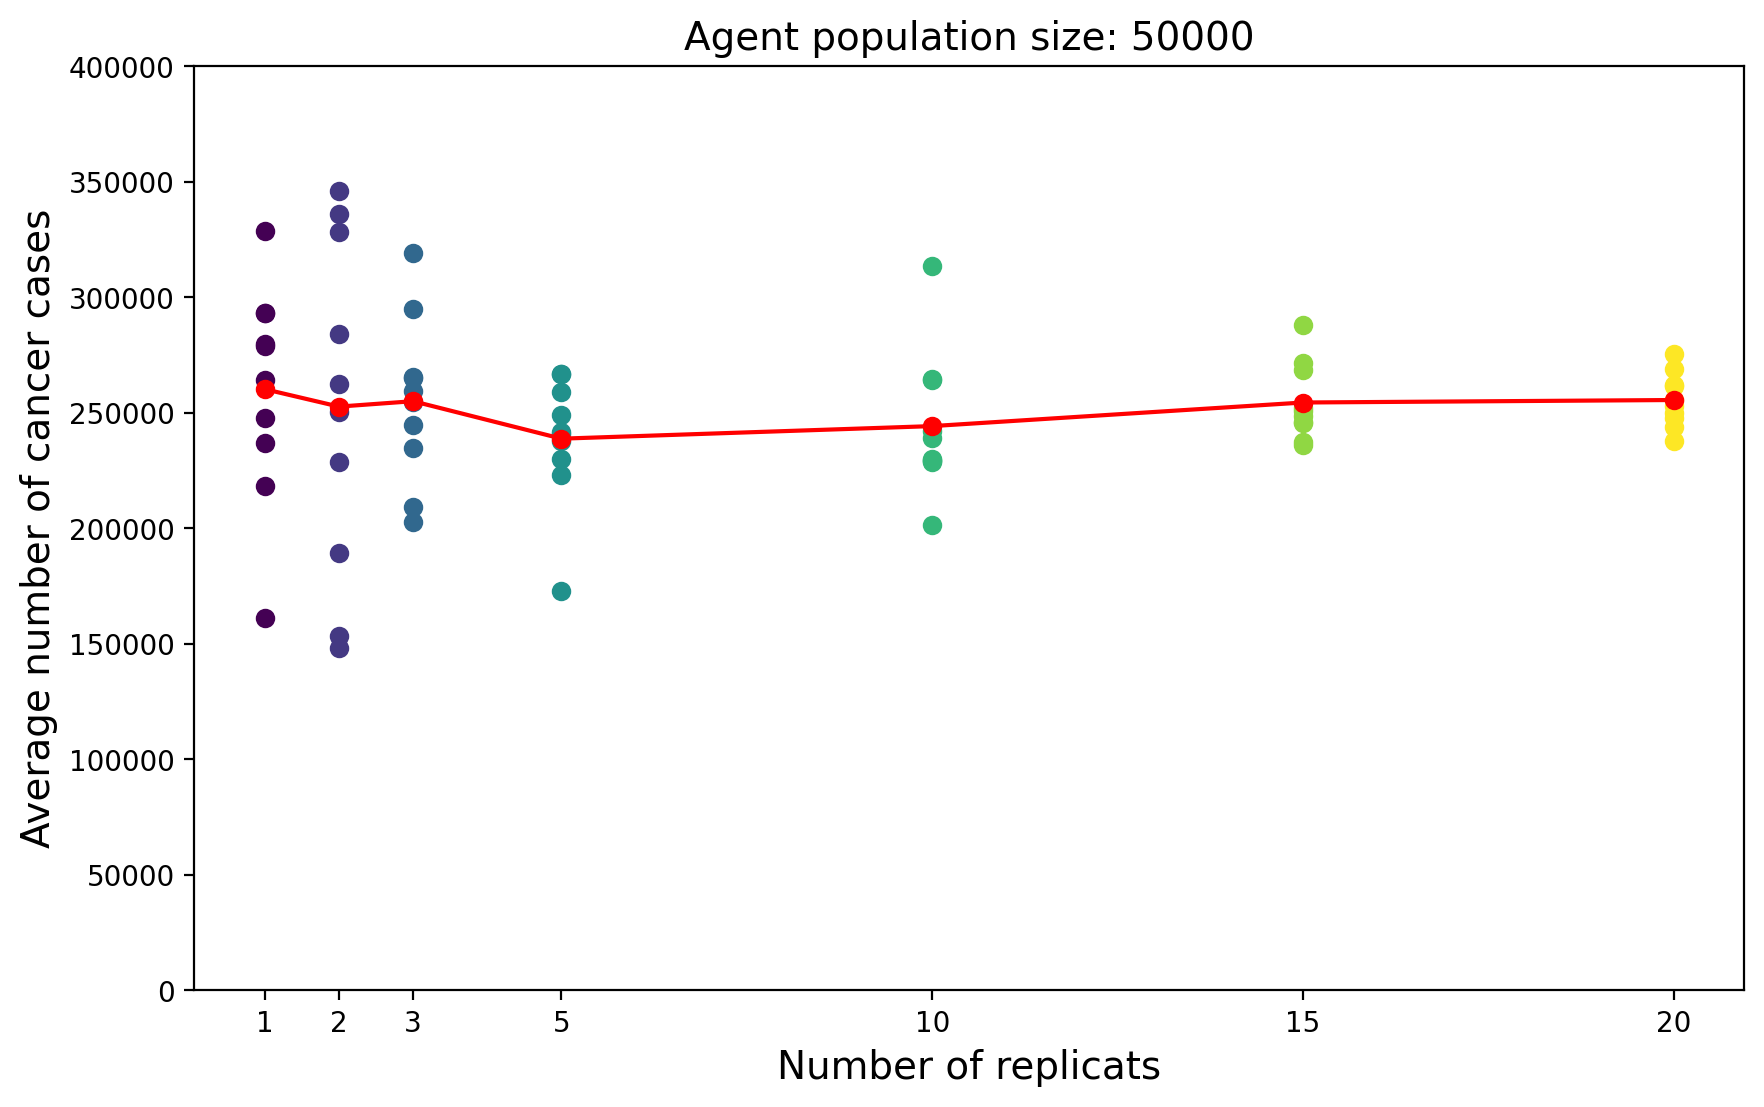

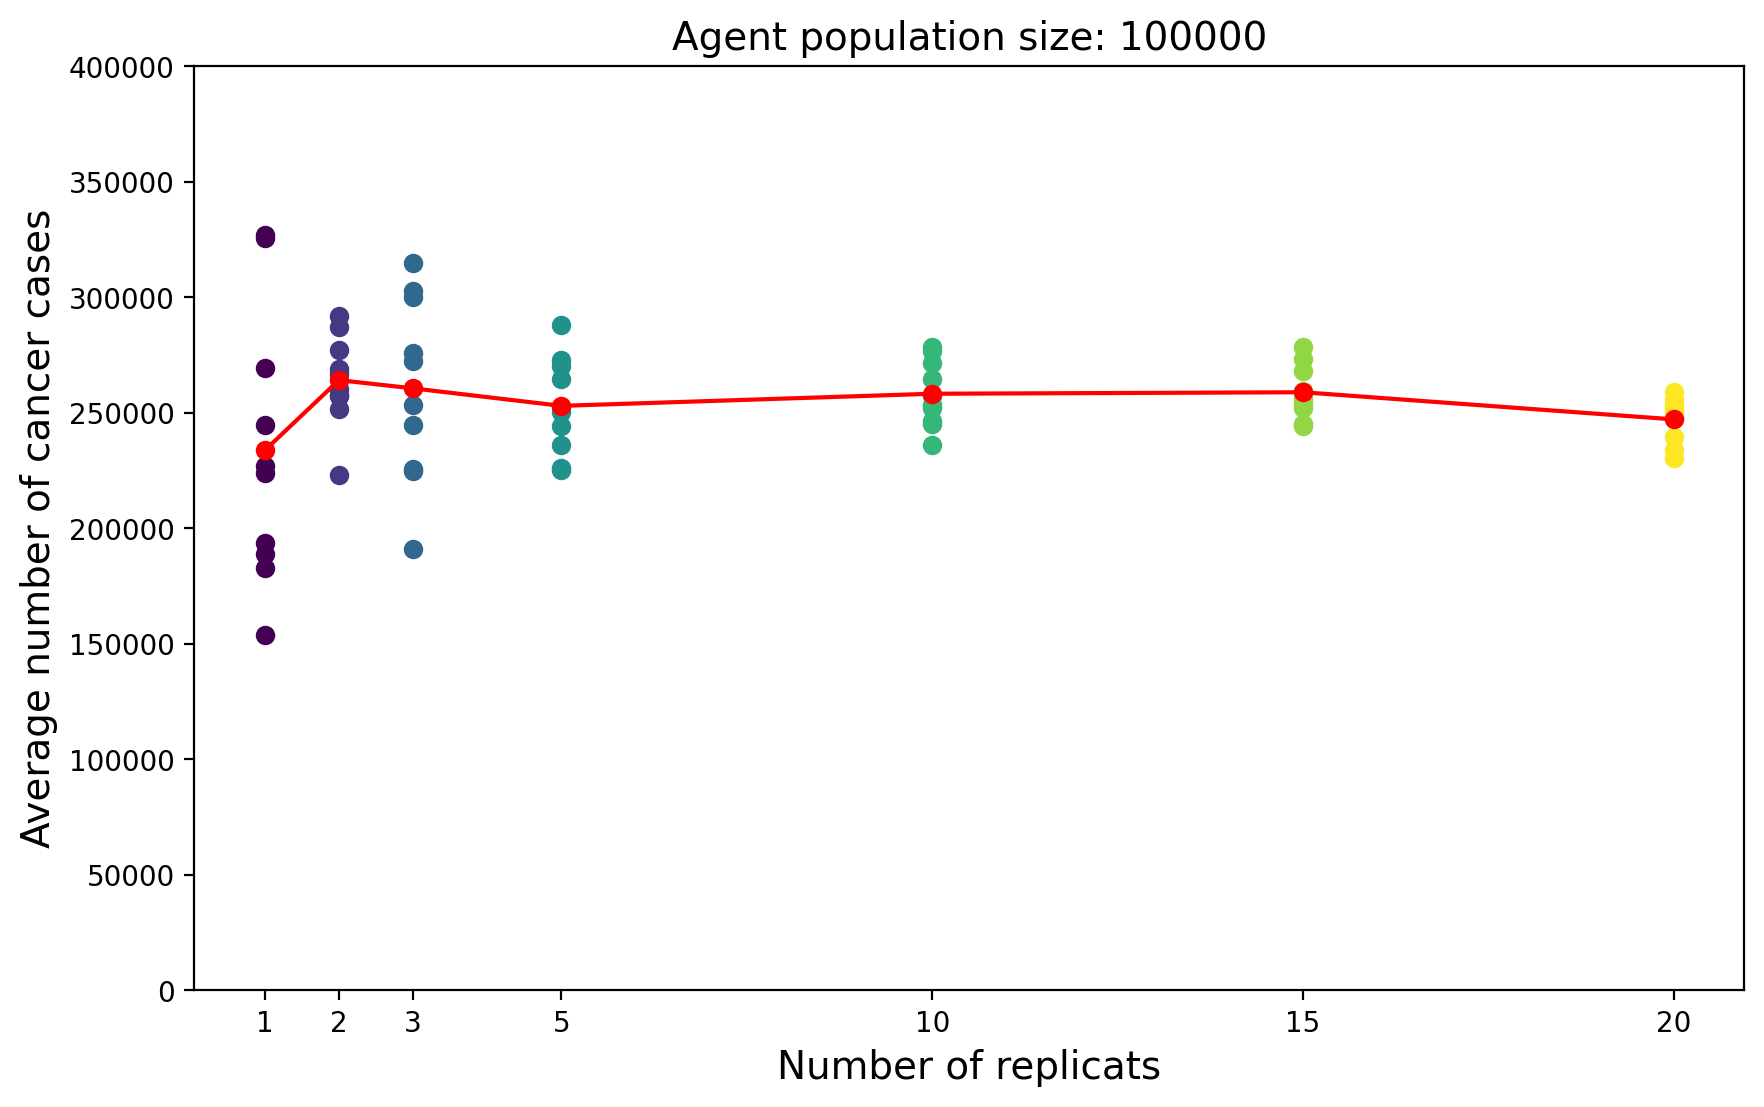

In [18]:
for i in range(len(agents)):
    plt.figure(figsize=(10, 6))
    means = []
    sample_sizes_for_means = []
    for j in range(len(all_result_means[i])):
        x = [sample_sizes[j]] * len(all_result_means[i][j])
        y = all_result_means[i][j]
        plt.scatter(x, y, color=colors[j])

        mean_y = np.mean(y)
        means.append(mean_y)
        sample_sizes_for_means.append(sample_sizes[j])
    
    plt.plot(sample_sizes_for_means, means, color='red', marker='o', linestyle='-')
    plt.xticks([1, 2, 3, 5, 10, 15, 20])
    plt.ylim(0, 400000)
    plt.xlabel("Number of replicats", fontsize=14)
    plt.ylabel("Average number of cancer cases", fontsize=14)
    plt.title(f"Agent population size: {agents[i]}", fontsize=14)
    plt.show()

## Evolution of the Standard Deviation vs number of replicates

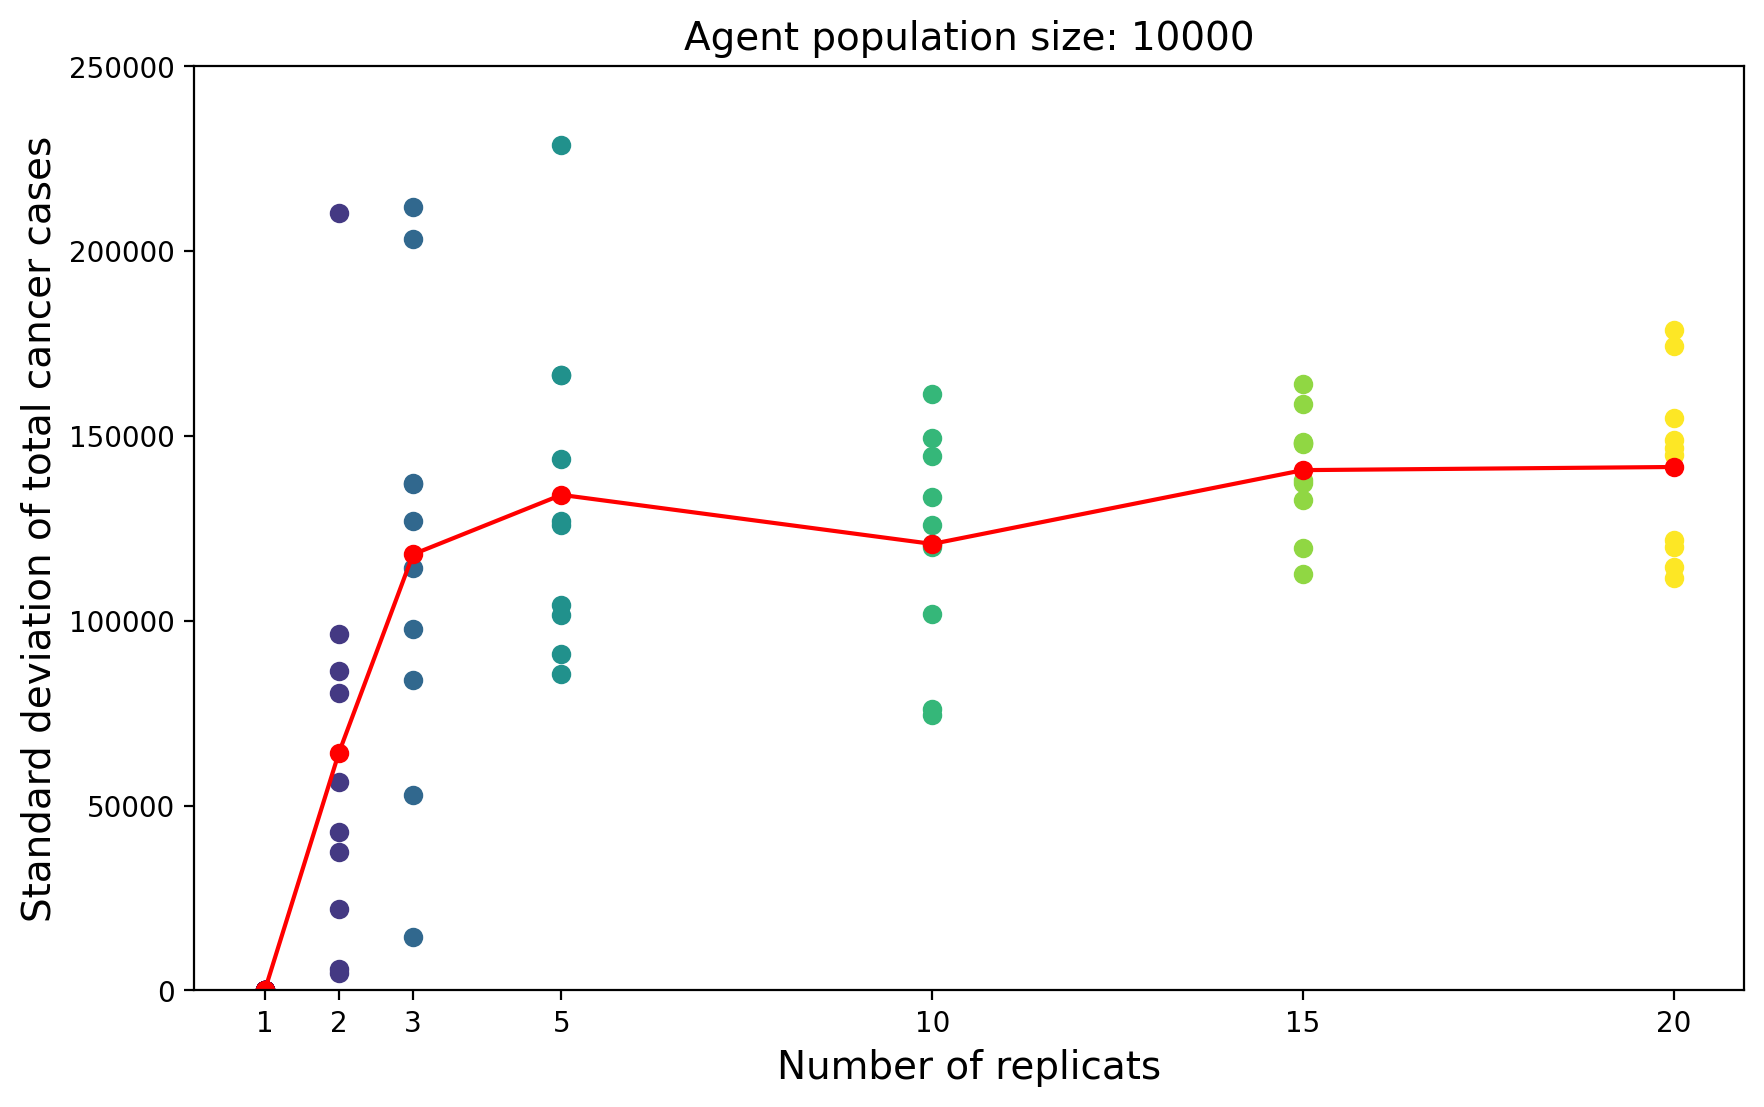

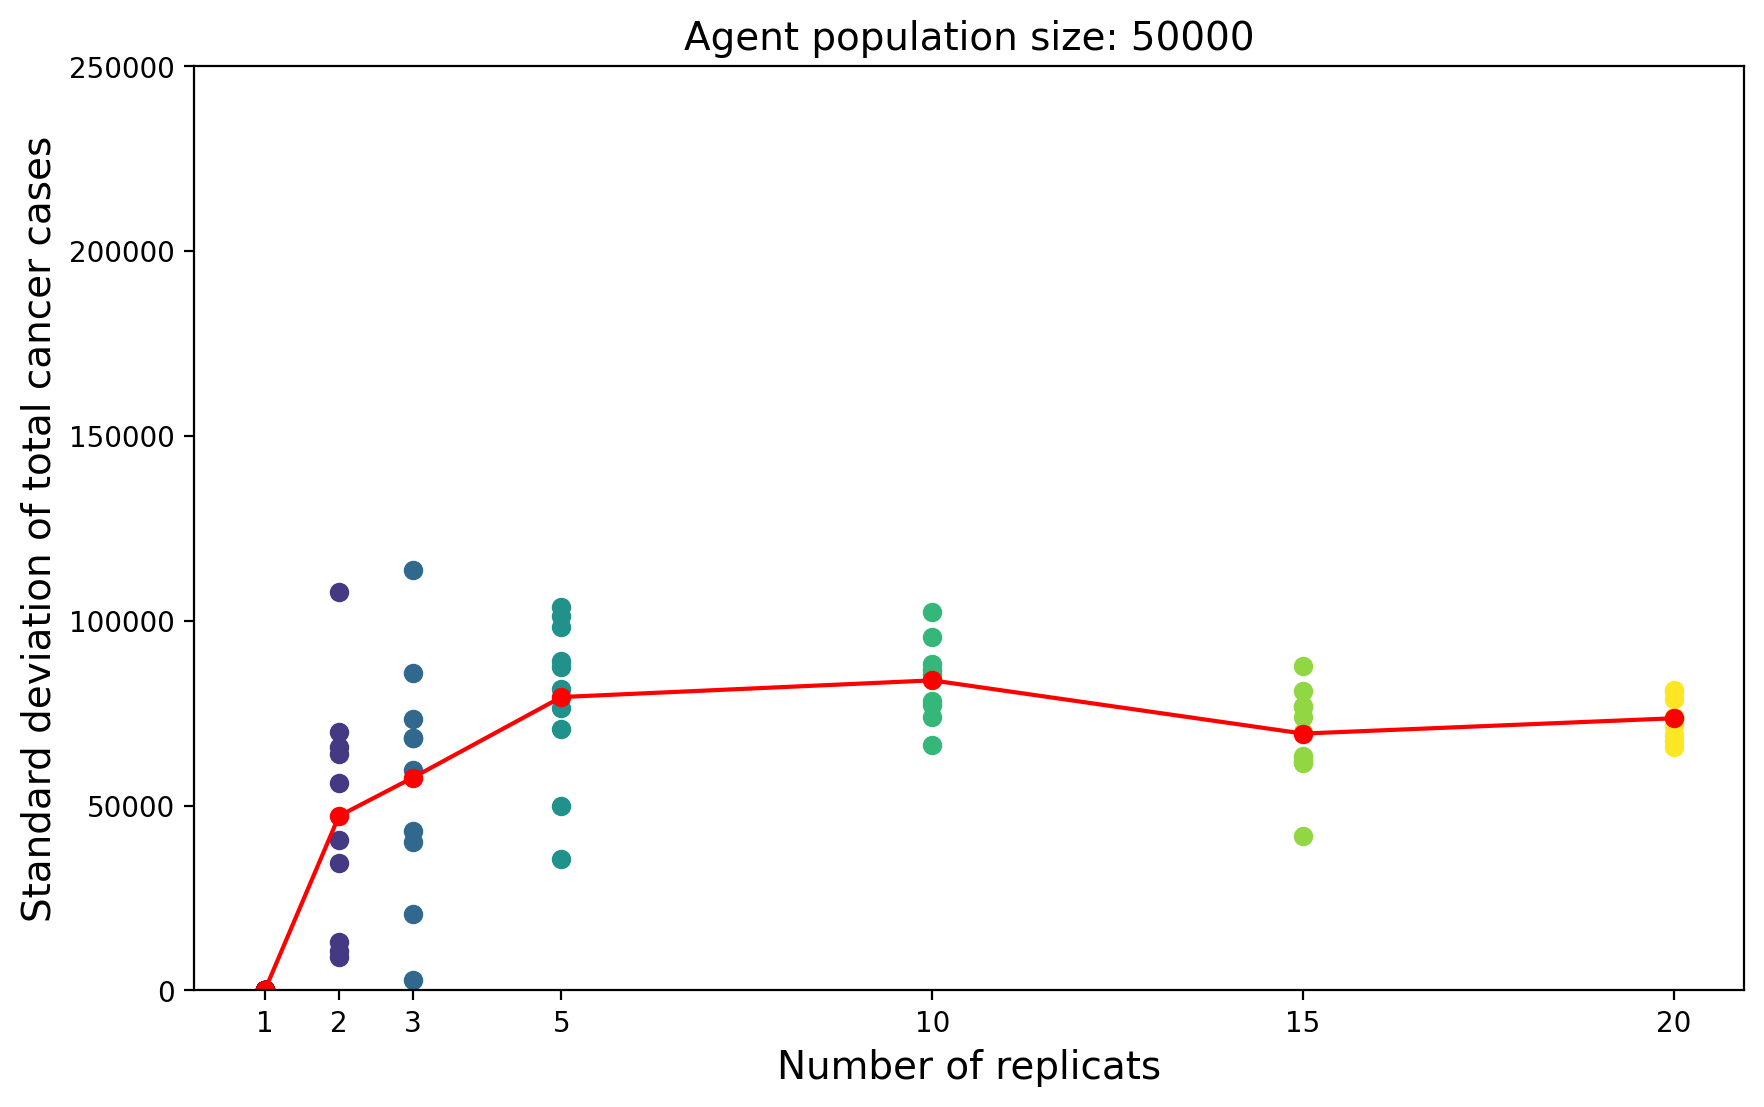

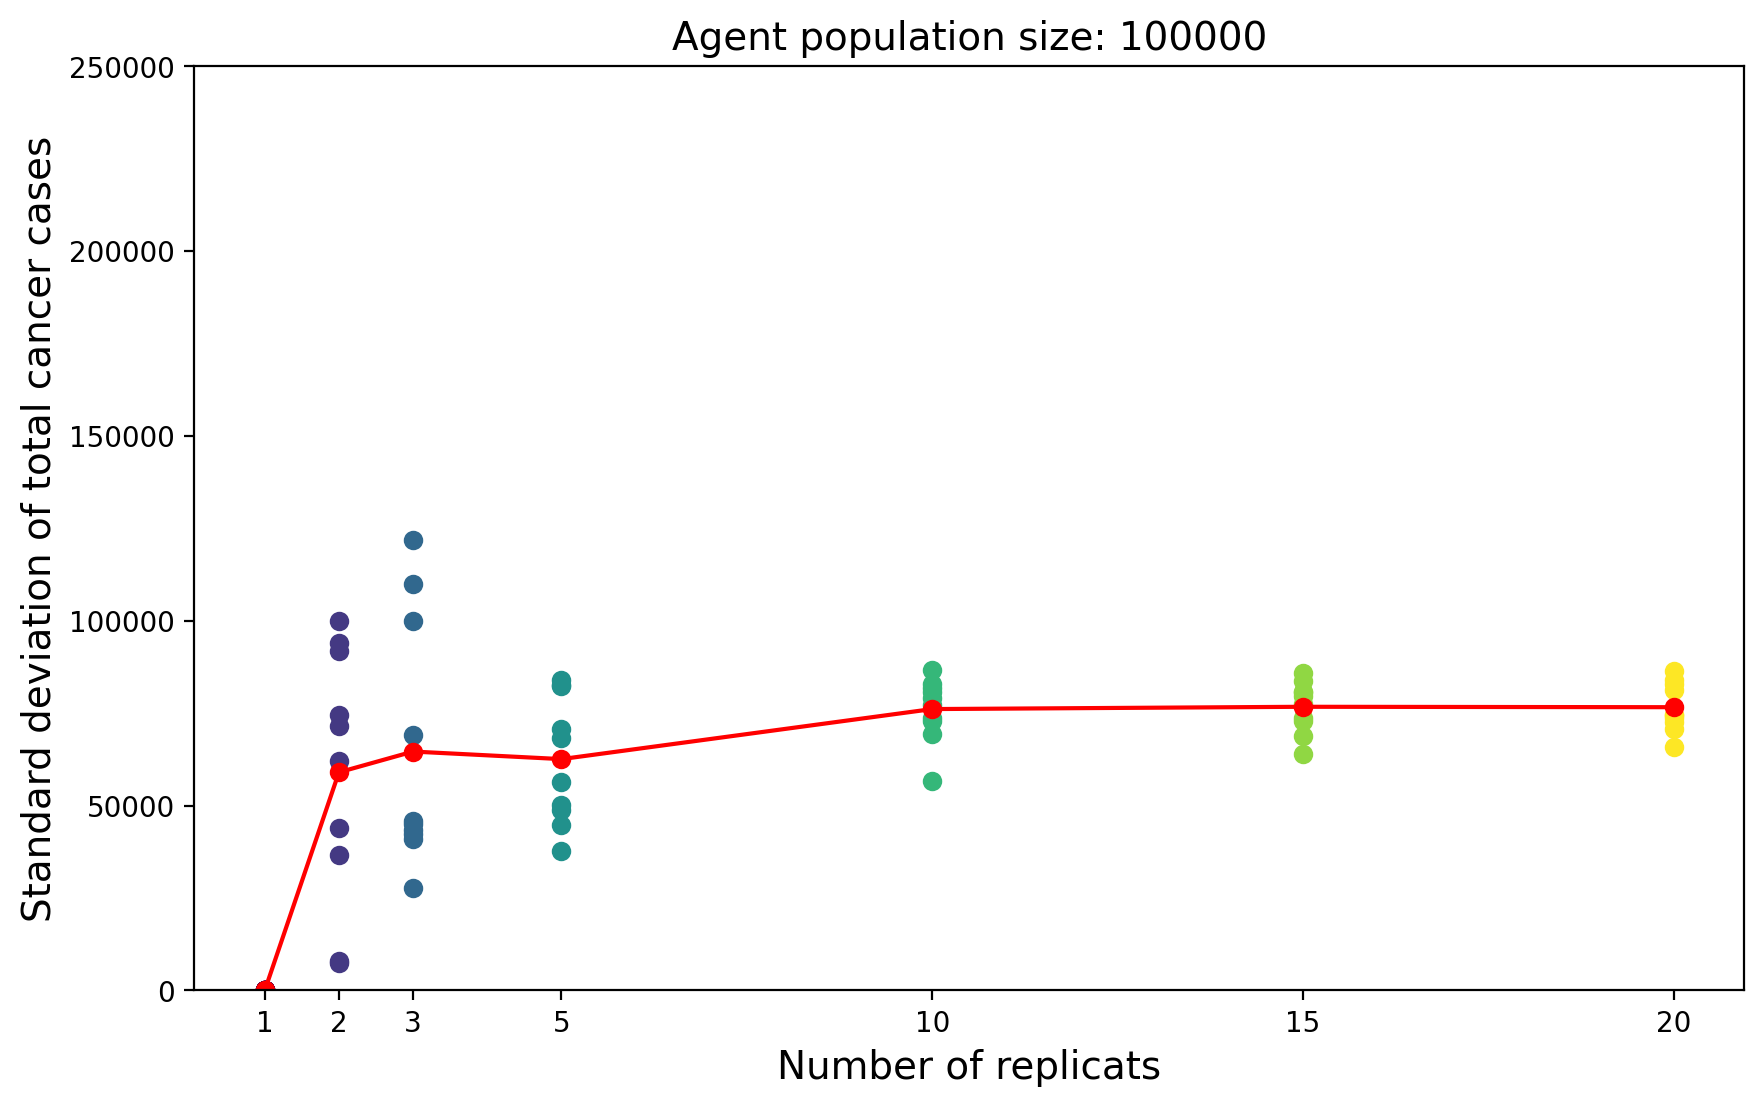

In [17]:
for i in range(len(agents)):
    plt.figure(figsize=(10, 6))
    std_devs = []
    sample_sizes_for_std_devs = []
    for j in range(len(all_result_std_dev[i])):
        x = [sample_sizes[j]] * len(all_result_std_dev[i][j])
        y = all_result_std_dev[i][j]
        if i==2:
            y = [a*1.5 for a in y]
        plt.scatter(x, y, color=colors[j])

        mean_y = np.mean(y)
        std_devs.append(mean_y)
        sample_sizes_for_std_devs.append(sample_sizes[j])
    
    plt.plot(sample_sizes_for_std_devs, std_devs, color='red', marker='o', linestyle='-')
    plt.ylim(0, 250000)
    plt.xticks([1, 2, 3, 5, 10, 15, 20])
    plt.xlabel("Number of replicats", fontsize=14)
    plt.ylabel("Standard deviation of total cancer cases", fontsize=14)
    plt.title(f"Agent population size: {agents[i]}", fontsize=14)
    plt.show()